In [1]:
# assume working in Jupyter Lab
%matplotlib notebook 

%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('../pywed')
sys.path.append('../IRFMtb')

import pywed as pw
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (8,5)

from control_room import *
from pulse_database import PulseDB

import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

from scipy.optimize import curve_fit 
from tqdm import tqdm

# Importing the database

In [58]:
# Importing Resumed Parameters
data = pd.read_csv('WEST_C4_database_resumed_parameters.csv')
data.head()

,Unnamed: 0,Ag18,Ag19,IC_Frequencies,IC_PCS_Phase_Q1,IC_PCS_Phase_Q2,IC_PCS_Phase_Q4,IC_PCS_Power_Q1,IC_PCS_Power_Q2,IC_PCS_Power_Q4,...,Rext_median,Separatrix_P,day,freq_Q1,freq_Q2,freq_Q4,month,nl,pulse,year
0,0,0.0,0.0,55.5,0.0,0.0,0.0,0.0,0.0,0.0,...,2992.12,2.068885,16,55.5,55.689999,55.700001,7,0.677500,54404,2019
1,1,0.0,0.0,55.5,0.0,0.0,0.0,0.0,0.0,0.0,...,2993.92,0.797955,16,55.5,55.689999,55.700001,7,0.964195,54404,2019
2,2,0.0,0.0,55.5,0.0,0.0,0.0,0.0,0.0,0.0,...,2947.24,-0.231872,16,55.5,55.689999,55.700001,7,1.185943,54404,2019
3,3,0.0,0.0,55.5,0.0,0.0,0.0,0.0,0.0,0.0,...,2889.28,0.209434,16,55.5,55.689999,55.700001,7,1.191996,54404,2019
4,4,0.0,0.0,55.5,0.0,0.0,0.0,0.0,0.0,0.0,...,2909.92,0.545797,16,55.5,55.689999,55.700001,7,1.199769,54404,2019


In [59]:
# create the date from the key year/month/day
data['date'] = pd.to_datetime(dict(year=data['year'], month=data['month'], day=data['day']))

# Power and requests

In [60]:
data.columns

Index(['Unnamed: 0', 'Ag18', 'Ag19', 'IC_Frequencies', 'IC_PCS_Phase_Q1',
       'IC_PCS_Phase_Q2', 'IC_PCS_Phase_Q4', 'IC_PCS_Power_Q1',
       'IC_PCS_Power_Q2', 'IC_PCS_Power_Q4', 'IC_P_Gen1', 'IC_P_Gen1_ref',
       'IC_P_Gen2', 'IC_P_Gen2_ref', 'IC_P_Gen3', 'IC_P_Gen3_ref', 'IC_P_Gen4',
       'IC_P_Gen4_ref', 'IC_P_Gen5', 'IC_P_Gen5_ref', 'IC_P_Gen6',
       'IC_P_Gen6_ref', 'IC_P_Q1', 'IC_P_Q1_left_fwd', 'IC_P_Q1_left_ref',
       'IC_P_Q1_right_fwd', 'IC_P_Q1_right_ref', 'IC_P_Q2', 'IC_P_Q2_left_fwd',
       'IC_P_Q2_left_ref', 'IC_P_Q2_right_fwd', 'IC_P_Q2_right_ref', 'IC_P_Q4',
       'IC_P_Q4_left_fwd', 'IC_P_Q4_left_ref', 'IC_P_Q4_right_fwd',
       'IC_P_Q4_right_ref', 'IC_P_tot', 'IC_Phase_Q1', 'IC_Phase_Q2',
       'IC_Phase_Q4', 'IC_Positions', 'IC_Rc_Q1_avg', 'IC_Rc_Q2_avg',
       'IC_Rc_Q4_avg', 'IC_Vacuum_Q1_left', 'IC_Vacuum_Q1_right',
       'IC_Vacuum_Q2_left', 'IC_Vacuum_Q2_right', 'IC_Vacuum_Q4_left',
       'IC_Vacuum_Q4_right', 'IC_Voltage_left_lower_Q1',
   

In [61]:
data['IC_P_Gen1_fwd'] = data['IC_P_Gen1'] + data['IC_P_Gen1_ref']
data['IC_P_Gen2_fwd'] = data['IC_P_Gen2'] + data['IC_P_Gen2_ref']
data['IC_P_Gen3_fwd'] = data['IC_P_Gen3'] + data['IC_P_Gen3_ref']
data['IC_P_Gen4_fwd'] = data['IC_P_Gen4'] + data['IC_P_Gen4_ref']
data['IC_P_Gen5_fwd'] = data['IC_P_Gen5'] + data['IC_P_Gen5_ref']
data['IC_P_Gen6_fwd'] = data['IC_P_Gen6'] + data['IC_P_Gen6_ref']

data['IC_P_Gen_Q1'] = data['IC_P_Gen5'] + data['IC_P_Gen6']
data['IC_P_Gen_Q2'] = data['IC_P_Gen1'] + data['IC_P_Gen2']
data['IC_P_Gen_Q4'] = data['IC_P_Gen3'] + data['IC_P_Gen4']

<IPython.core.display.Javascript object>


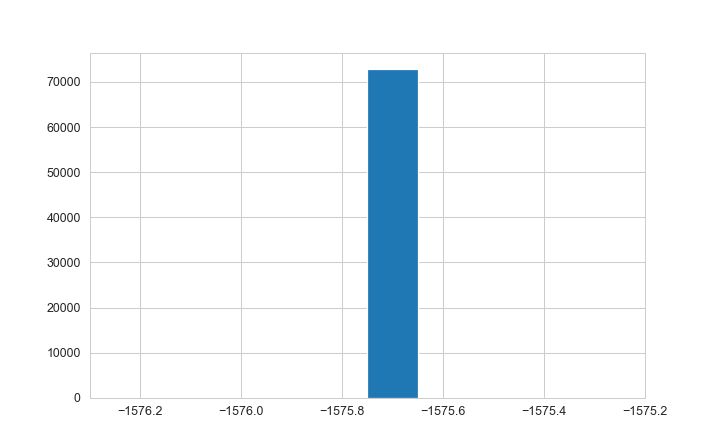

In [67]:
fig, ax = plt.subplots()
data['IC_P_Gen5_ref'].hist(ax=ax)


<IPython.core.display.Javascript object>


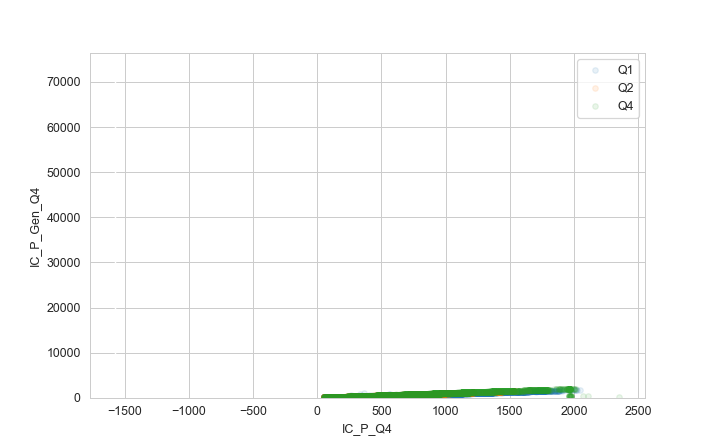

In [62]:
fig, ax = plt.subplots()
data.query('IC_P_Gen_Q1 > 50 and IC_P_Q1 > 50').plot(ax=ax, x='IC_P_Q1', y='IC_P_Gen_Q1', kind='scatter', alpha=0.1, color='C0')
data.query('IC_P_Gen_Q2 > 50 and IC_P_Q2 > 50').plot(ax=ax, x='IC_P_Q2', y='IC_P_Gen_Q2', kind='scatter', alpha=0.1, color='C1')
data.query('IC_P_Gen_Q4 > 50 and IC_P_Q4 > 50').plot(ax=ax, x='IC_P_Q4', y='IC_P_Gen_Q4', kind='scatter', alpha=0.1, color='C2')
#ax.plot([0, 2000], [0, 2000], color='k', label='y=x')
ax.legend(('Q1', 'Q2', 'Q4'))

<IPython.core.display.Javascript object>


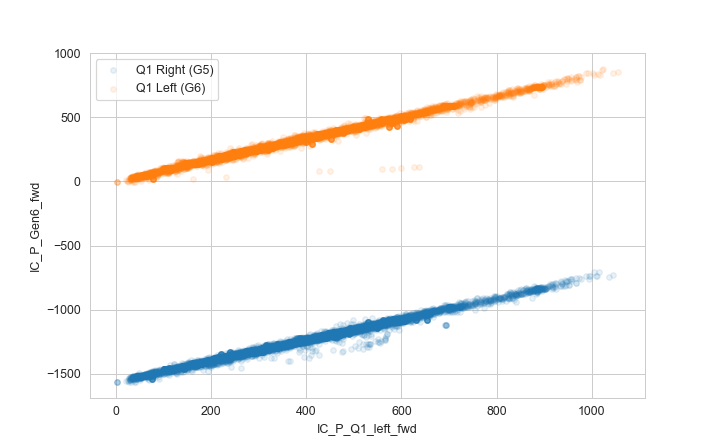

In [48]:
fig, ax = plt.subplots()
data.query('IC_P_Q1 > 50').plot(ax=ax, x='IC_P_Q1_right_fwd', y='IC_P_Gen5_fwd', 
                                kind='scatter', alpha=0.1, label='Q1 Right (G5)', color='C0')
data.query('IC_P_Q1 > 50').plot(ax=ax, x='IC_P_Q1_left_fwd', y='IC_P_Gen6_fwd', 
                                kind='scatter', alpha=0.1, label='Q1 Left (G6)', color='C1')

<IPython.core.display.Javascript object>


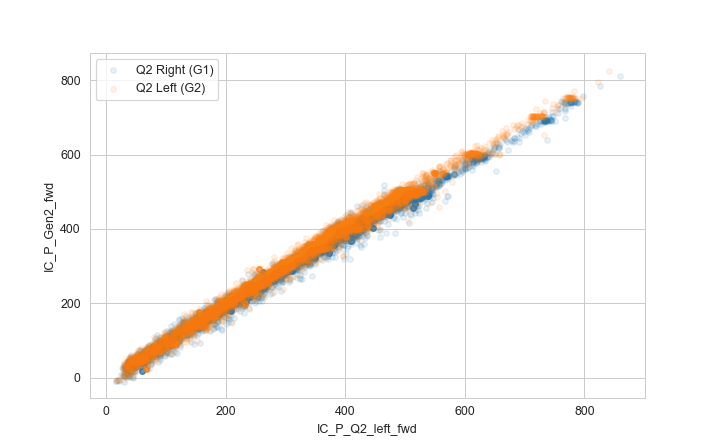

In [52]:
fig, ax = plt.subplots()
data.query('IC_P_Q2 > 50').plot(ax=ax, x='IC_P_Q2_right_fwd', y='IC_P_Gen1_fwd', 
                                kind='scatter', alpha=0.1, label='Q2 Right (G1)', color='C0')
data.query('IC_P_Q2 > 50').plot(ax=ax, x='IC_P_Q2_left_fwd', y='IC_P_Gen2_fwd', 
                                kind='scatter', alpha=0.1, label='Q2 Left (G2)', color='C1')


<IPython.core.display.Javascript object>


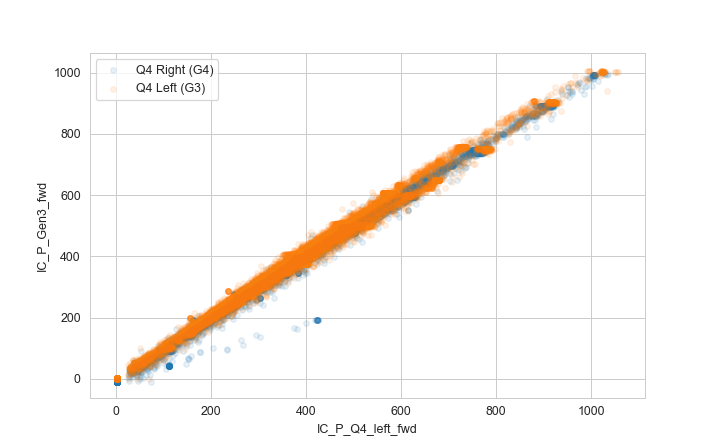

In [53]:
fig, ax = plt.subplots()
data.query('IC_P_Q4 > 50').plot(ax=ax, x='IC_P_Q4_right_fwd', y='IC_P_Gen4_fwd', 
                                kind='scatter', alpha=0.1, label='Q4 Right (G4)', color='C0')
data.query('IC_P_Q4 > 50').plot(ax=ax, x='IC_P_Q4_left_fwd', y='IC_P_Gen3_fwd', 
                                kind='scatter', alpha=0.1, label='Q4 Left (G3)', color='C1')


# Derived quantities

In [4]:
data['Ptot'] = data['Ohmic_P'] + data['LH_P_tot'] + data['IC_P_tot']/1e3
data['P_conv'] = data['Ptot'] - data['Prad']
data['frad'] = data['Prad']/data['Ptot']
data['frad_bulk'] = data['Prad_bulk']/data['Ptot']

In [5]:
data['ROG_Q1'] = data['R_Q1']*1e3 - data['Rext_median']
data['ROG_Q2'] = data['R_Q2']*1e3 - data['Rext_median']
data['ROG_Q4'] = data['R_Q4']*1e3 - data['Rext_median']


In [6]:
data['P_conv_ratio'] = data['P_conv']/(data['IC_P_tot']*1e-3)

In [7]:
data.query('IC_P_tot > 500 and P_conv > 0.5')['P_conv'].min()

0.5000025928005768

# Max Power Statistics

Taking the maximum power per plasma pulse

In [29]:
data.query('IC_P_tot > 0 and year>=2019').groupby('pulse').max()

,Unnamed: 0,Ag18,Ag19,IC_Frequencies,IC_P_Q1,IC_P_Q2,IC_P_Q4,IC_P_tot,IC_Phase_Q1,IC_Phase_Q2,...,Rext_median,Separatrix_P,day,freq_Q1,freq_Q2,freq_Q4,month,nl,year,date
pulse,,,,,,,,,,,,,,,,,,,,,
54404,75,0.0,0.0,55.5,26.773470,11.587755,18.540817,44.020409,67.297882,37.425510,...,2980.960000,0.333443,16,55.5,55.689999,55.700001,7,2.718894,2019,2019-07-16
54405,75,0.0,0.0,55.5,66.728572,0.218367,103.861226,145.446941,203.524898,7.303696,...,2982.720000,0.312631,16,55.5,55.689999,55.700001,7,2.819640,2019,2019-07-16
54406,75,0.0,0.0,55.5,102.008165,35.663266,102.832655,203.624493,47.302856,87.840815,...,2980.680000,0.382562,16,55.5,55.689999,55.700001,7,3.022031,2019,2019-07-16
54407,74,0.0,0.0,55.5,101.940818,29.459184,105.963267,228.551024,344.640625,56.833264,...,2990.666667,0.471871,16,55.5,55.689999,55.700001,7,3.201103,2019,2019-07-16
54410,95,0.0,0.0,55.5,0.000000,22.567347,164.569390,177.685717,0.000000,34.582244,...,2983.125000,0.416897,16,55.5,55.689999,55.700001,7,3.291760,2019,2019-07-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55802,154,214.2,214.2,55.5,1380.906271,1337.902103,1094.664600,3762.375000,179.798121,221.419791,...,2946.666667,4.536049,7,55.5,55.900002,56.049999,11,4.417016,2019,2019-11-07
55803,154,214.0,214.0,55.5,1175.750018,1014.233348,978.216681,3164.645833,179.821871,229.767703,...,2946.583333,3.886865,7,55.5,55.900002,56.049999,11,4.259761,2019,2019-11-07
55805,136,168.8,168.8,55.5,819.683346,677.562510,661.893760,2157.666667,179.806454,222.422912,...,2946.041667,2.810570,7,55.5,55.900002,56.049999,11,4.444818,2019,2019-11-07


In [41]:
data_max_power = data.query('IC_P_tot > 0 and year>=2019').groupby('pulse').max()
data_max_power['P'] = data_max_power['IC_P_tot']/1e3

In [45]:
data_max_power=data_max_power.reset_index()  # create a counter of plasma

In [46]:
data_max_power

,pulse,Unnamed: 0,Ag18,Ag19,IC_Frequencies,IC_P_Q1,IC_P_Q2,IC_P_Q4,IC_P_tot,IC_Phase_Q1,...,Separatrix_P,day,freq_Q1,freq_Q2,freq_Q4,month,nl,year,date,P
0,54404,75,0.0,0.0,55.5,26.773470,11.587755,18.540817,44.020409,67.297882,...,0.333443,16,55.5,55.689999,55.700001,7,2.718894,2019,2019-07-16,0.044020
1,54405,75,0.0,0.0,55.5,66.728572,0.218367,103.861226,145.446941,203.524898,...,0.312631,16,55.5,55.689999,55.700001,7,2.819640,2019,2019-07-16,0.145447
2,54406,75,0.0,0.0,55.5,102.008165,35.663266,102.832655,203.624493,47.302856,...,0.382562,16,55.5,55.689999,55.700001,7,3.022031,2019,2019-07-16,0.203624
3,54407,74,0.0,0.0,55.5,101.940818,29.459184,105.963267,228.551024,344.640625,...,0.471871,16,55.5,55.689999,55.700001,7,3.201103,2019,2019-07-16,0.228551
4,54410,95,0.0,0.0,55.5,0.000000,22.567347,164.569390,177.685717,0.000000,...,0.416897,16,55.5,55.689999,55.700001,7,3.291760,2019,2019-07-16,0.177686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,55802,154,214.2,214.2,55.5,1380.906271,1337.902103,1094.664600,3762.375000,179.798121,...,4.536049,7,55.5,55.900002,56.049999,11,4.417016,2019,2019-11-07,3.762375
353,55803,154,214.0,214.0,55.5,1175.750018,1014.233348,978.216681,3164.645833,179.821871,...,3.886865,7,55.5,55.900002,56.049999,11,4.259761,2019,2019-11-07,3.164646
354,55805,136,168.8,168.8,55.5,819.683346,677.562510,661.893760,2157.666667,179.806454,...,2.810570,7,55.5,55.900002,56.049999,11,4.444818,2019,2019-11-07,2.157667
355,55807,124,28.8,28.8,55.5,443.879173,355.977089,349.752089,1148.250000,180.097079,...,3.839102,7,55.5,55.900002,56.049999,11,3.417052,2019,2019-11-07,1.148250


<IPython.core.display.Javascript object>


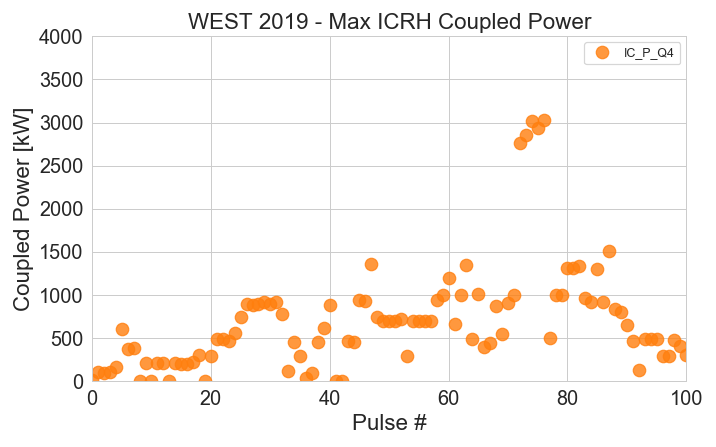

In [55]:
fig, ax = plt.subplots()

data_max_power.plot(y='IC_P_Q4', marker='.', ms=20, ls='', ax=ax, alpha=.8, c='C1')

ax.set_xlabel('Pulse #', fontsize=18)
ax.set_ylabel('Coupled Power [kW]', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_ylim(0,4000)
ax.set_xlim(0,100)
#ax.axhline(1.2, color='k', alpha=0.5, ls='--', lw=2)
ax.set_title('WEST 2019 - Max ICRH Coupled Power', fontsize=18)
fig.tight_layout()

<IPython.core.display.Javascript object>


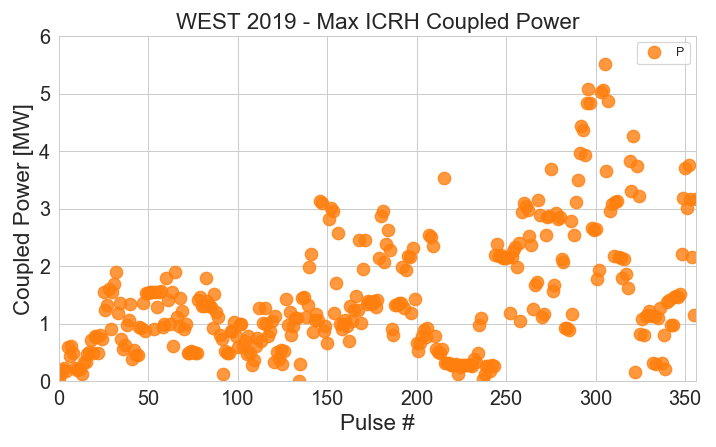

In [52]:
fig, ax = plt.subplots()

data_max_power.plot(y='P', marker='.', ms=20, ls='', ax=ax, alpha=.8, c='C1')

ax.set_xlabel('Pulse #', fontsize=18)
ax.set_ylabel('Coupled Power [MW]', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_ylim(0,6)
#ax.axhline(1.2, color='k', alpha=0.5, ls='--', lw=2)
ax.set_title('WEST 2019 - Max ICRH Coupled Power', fontsize=18)
fig.tight_layout()

#fig.savefig('WEST_C4_ICRH_max_power.png', dpi=150)

<IPython.core.display.Javascript object>


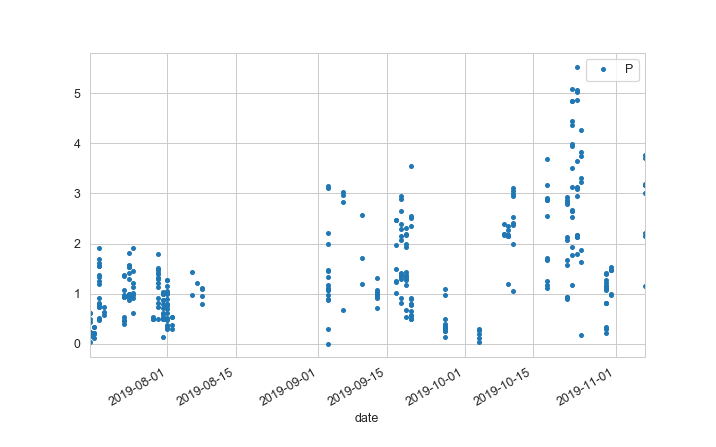

In [25]:
data_max_power.plot(x='date', y='P', marker='.', ls='')

<IPython.core.display.Javascript object>


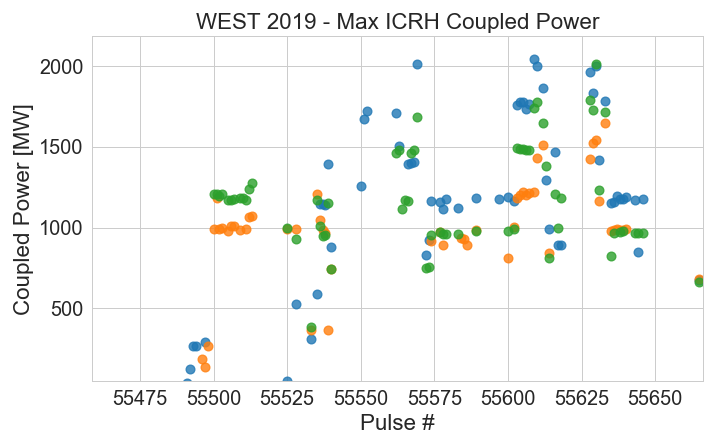

In [60]:
fig, ax = plt.subplots()

data_max_power.plot(kind='scatter', x='pulse', y='IC_P_Q1', s=50, ax=ax, alpha=.8, c='C0')
data_max_power.plot(kind='scatter', x='pulse', y='IC_P_Q2', s=50, ax=ax, alpha=.8, c='C1')
data_max_power.plot(kind='scatter', x='pulse', y='IC_P_Q4', s=50, ax=ax, alpha=.8, c='C2')

ax.set_xlabel('Pulse #', fontsize=18)
ax.set_ylabel('Coupled Power [MW]', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_ylim(0,3000)
#ax.axhline(1.2, color='k', alpha=0.5, ls='--', lw=2)
ax.set_title('WEST 2019 - Max ICRH Coupled Power', fontsize=18)
fig.tight_layout()

#fig.savefig('WEST_C4_ICRH_max_power_vs_date.png', dpi=150)

<IPython.core.display.Javascript object>


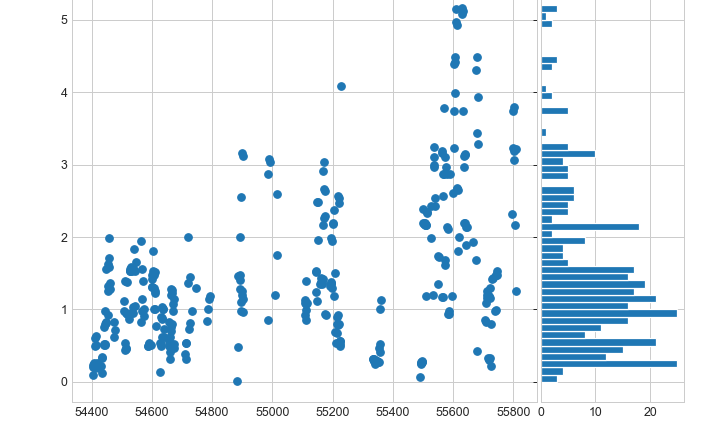

(-0.2804228946344829, 5.900807105258284)

In [17]:
# Fixing random state for reproducibility

# the random data
x = test['pulse']
y = test['P']

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 1
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure()

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)

ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y)
# now determine nice limits by hand:
binwidth = 0.1

bins = np.arange(0, 6 + binwidth, binwidth)

ax_histy.hist(y, bins=bins, orientation='horizontal')


ax_histy.set_ylim(ax_scatter.get_ylim())


# Plasma configuration

In [20]:
data['Xpoint'] = 'LSN'
USN_list = np.r_[55227, 55174, 55173, 55172, 55171, 55170]
USN_list = np.append(USN_list, np.arange(54882, 54892))
USN_list = np.append(USN_list, np.arange(54894, 54903))
data.loc[data['pulse'].isin(USN_list), 'Xpoint'] = 'USN'


# radiated power statistics

<IPython.core.display.Javascript object>


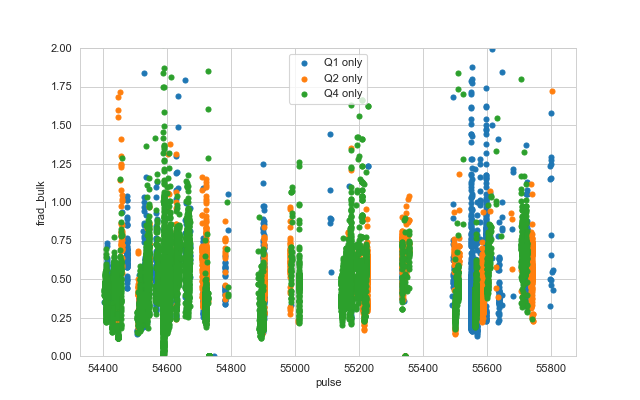

(0, 2)

In [21]:
fig, ax = plt.subplots()
data.query('IC_P_Q1 > 100 and IC_P_Q2 < 100 and IC_P_Q4 < 100').plot(kind='scatter', x='pulse', y='frad_bulk', color='C0', label='Q1 only', ax=ax)
data.query('IC_P_Q1 < 100 and IC_P_Q2 > 100 and IC_P_Q4 < 100').plot(kind='scatter', x='pulse', y='frad_bulk', color='C1', label='Q2 only', ax=ax)
data.query('IC_P_Q1 < 100 and IC_P_Q2 < 100 and IC_P_Q4 > 100').plot(kind='scatter', x='pulse', y='frad_bulk', color='C2', label='Q4 only', ax=ax)
ax.set_ylim(0, 2)

<IPython.core.display.Javascript object>


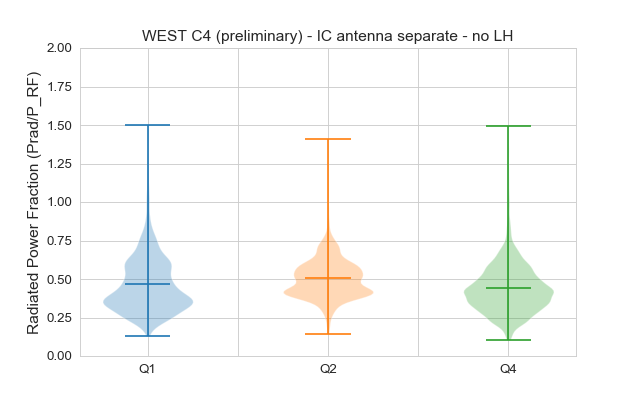

In [22]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 100 and IC_P_Q2 < 100 and IC_P_Q4 < 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [0],  widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 < 100 and IC_P_Q2 > 100 and IC_P_Q4 < 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [1], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 < 100 and IC_P_Q2 < 100 and IC_P_Q4 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [2], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Radiated Power Fraction (Prad/P_RF)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) - IC antenna separate - no LH', fontsize=14)
ax.grid(True)
ax.set_ylim(0,2)

fig.savefig('WEST_C4_IC_frad_vs_antenna.png', dpi=150)

<IPython.core.display.Javascript object>


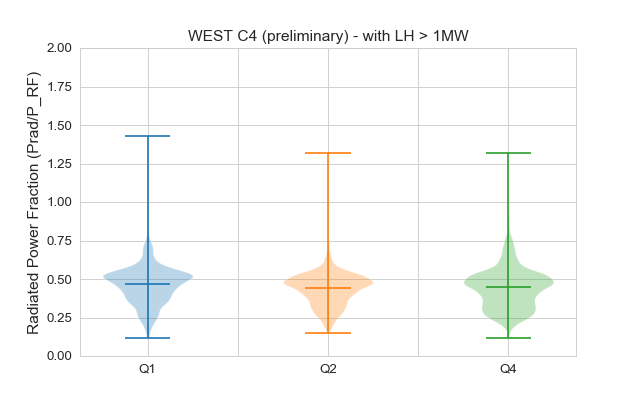

In [23]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot > 1 and IC_P_Q1 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [0],  widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 1 and IC_P_Q2 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [1], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 1 and IC_P_Q4 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [2], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Radiated Power Fraction (Prad/P_RF)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) - with LH > 1MW', fontsize=14)
ax.grid(True)
ax.set_ylim(0,2)

fig.savefig('WEST_C4_IC_frad_vs_antenna_with_LH.png', dpi=150)

<IPython.core.display.Javascript object>


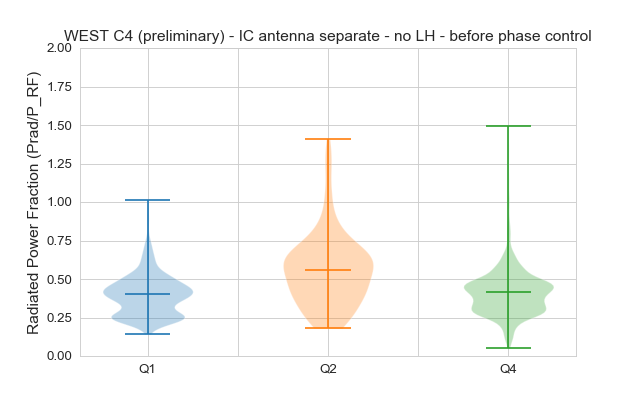

(0, 2)

In [16]:
pulse_ref = 54626
                        
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse < @pulse_ref and IC_P_Q1 > 100 and IC_P_Q2 < 100 and IC_P_Q4 < 100 and frad_bulk > 0.05 and frad_bulk < 1.5')['frad_bulk'].dropna(), [0],  widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse < @pulse_ref and IC_P_Q1 < 100 and IC_P_Q2 > 100 and IC_P_Q4 < 100 and frad_bulk > 0.05 and frad_bulk < 1.5')['frad_bulk'].dropna(), [1], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse < @pulse_ref and IC_P_Q1 < 100 and IC_P_Q2 < 100 and IC_P_Q4 > 100 and frad_bulk > 0.05 and frad_bulk < 1.5')['frad_bulk'].dropna(), [2], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Radiated Power Fraction (Prad/P_RF)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) - IC antenna separate - no LH - before phase control', fontsize=14)
ax.grid(True)
ax.set_ylim(0,2)
                         

<IPython.core.display.Javascript object>


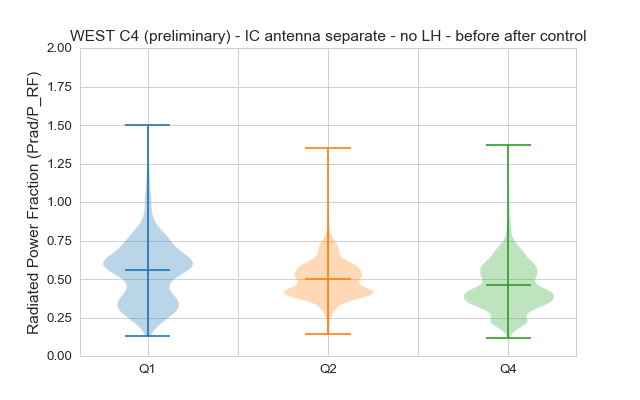

(0, 2)

In [24]:
pulse_ref = 54626
                        
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse > 55525 and IC_P_Q1 > 100 and IC_P_Q2 < 100 and IC_P_Q4 < 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [0],  widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse > @pulse_ref and IC_P_Q1 < 100 and IC_P_Q2 > 100 and IC_P_Q4 < 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [1], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse > @pulse_ref and IC_P_Q1 < 100 and IC_P_Q2 < 100 and IC_P_Q4 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [2], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Radiated Power Fraction (Prad/P_RF)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) - IC antenna separate - no LH - before after control', fontsize=14)
ax.grid(True)
ax.set_ylim(0,2)

# Link between radiated power and LCFS radius

In [25]:
data.query('IC_P_tot > 500 and P_conv > 0.5')['P_conv'].min()

0.5000025928005768

<IPython.core.display.Javascript object>


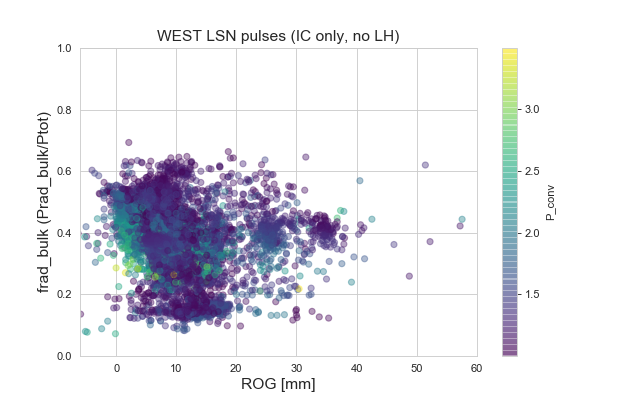

Text(0.5, 1.0, 'WEST LSN pulses (IC only, no LH)')

In [26]:
fig, ax = plt.subplots()
data.query('IC_P_tot > 500 and LH_P_tot < 0.1 and P_conv > 1 and frad > 0.05 and Xpoint == "LSN"').\
    plot(kind='scatter', x='ROG_Q4', y='frad_bulk', ax=ax,
    c='P_conv', cmap='viridis', alpha=0.4, s=30)
ax.set_xlim(-6, 60)
ax.set_ylim(0, 1)
ax.set_xlabel('ROG [mm]', fontsize=14)
ax.set_ylabel('frad_bulk (Prad_bulk/Ptot)', fontsize=14)
ax.set_title('WEST LSN pulses (IC only, no LH)', fontsize=14)

In [ ]:
data.query('IC_P_Q4 > 300 and LH_P_tot > 0.1 and Xpoint == "LSN"').\
    plot(kind='scatter', x='LH_P_tot', y='IC_Rc_Q4_avg', 
         alpha=0.2, c='Rext_median', cmap='viridis')

# Shot-Averaged parameters
Here we average the dataset for each shot, in order to seek for specific shot-behaviour.

In [27]:
exclude = [54587,54588,54589,54590,54591]
query = 'IC_P_Q4 > 500 and pulse not in @exclude and LH_P_tot < 0.1'# and IC_P_Q1 < 50 and IC_P_Q2 < 50'
pulse_mean = data.query(query).groupby(['pulse']).mean()
pulse_std = data.query(query).groupby(['pulse']).std()
pulse_max = data.query(query).groupby(['pulse']).max()
pulses = pulse_mean.index

<IPython.core.display.Javascript object>


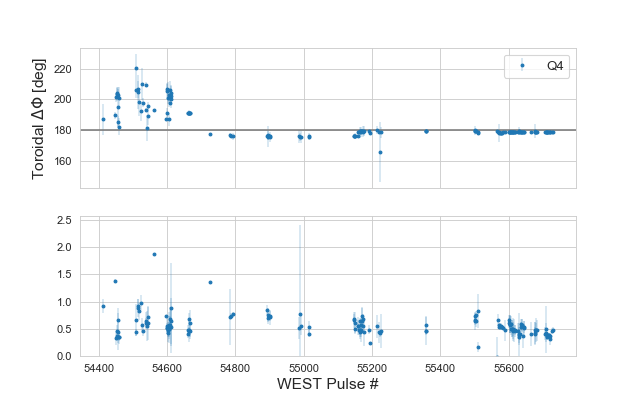

In [28]:
def plot_errorbar(sig_name, axe, label=None):
    markers, caps, bars = axe.errorbar(pulses, 
                                  pulse_mean[sig_name], 
                                  yerr=pulse_std[sig_name], 
                                  ls='', marker='.', ms=5, label=label)
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.2) for bar in bars]

fig, ax = plt.subplots(2, 1, sharex=True)
#plot_errorbar('IC_delta_phi_toro_Q1_Bot_LmR', ax[0], label='Q1')
#plot_errorbar('IC_delta_phi_toro_Q2_Top_LmR', ax[0], label='Q2')
plot_errorbar('IC_delta_phi_toro_Q4_Top_LmR', ax[0], label='Q4')

plot_errorbar('P_conv_ratio', ax[1])
ax[1].set_ylim(bottom=0)

ax[0].axhline(180, color='gray')
ax[-1].set_xlabel('WEST Pulse #', fontsize=14)
ax[0].set_ylabel('Toroidal $\Delta \Phi$ [deg]', fontsize=14)
ax[0].legend(fontsize=12)


In [ ]:
data.query('IC_P_Q4 > 500 and LH_P_tot < 0.1 and IC_P_Q1 < 50 and IC_P_Q2 < 50').\
    plot(kind='scatter', x='IC_delta_phi_toro_Q1_Bot_LmR', y='Prad', 
                                 alpha=.9)


# Radiated Power Analysis

In [29]:
# Define plasma configuration
data['Xpoint'] = 'LSN'
USN_list = np.r_[55227, 55174, 55173, 55172, 55171, 55170]
USN_list = np.append(USN_list, np.arange(54882, 54892))
USN_list = np.append(USN_list, np.arange(54894, 54903))
print(USN_list)
data.loc[data['pulse'].isin(USN_list), 'Xpoint'] = 'USN'

[55227 55174 55173 55172 55171 55170 54882 54883 54884 54885 54886 54887
 54888 54889 54890 54891 54894 54895 54896 54897 54898 54899 54900 54901
 54902]


# Total Power

<IPython.core.display.Javascript object>


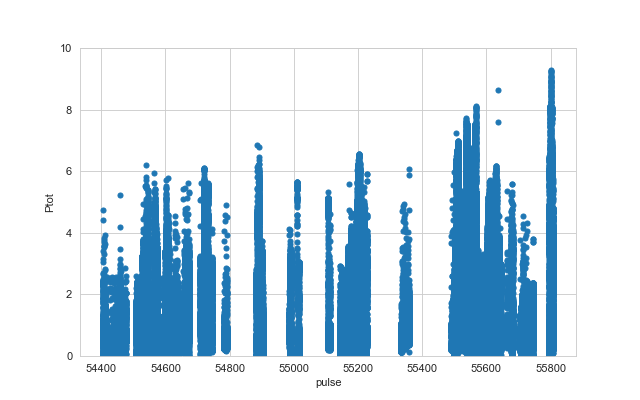

(0, 10)

In [30]:
fig, ax = plt.subplots()
data.plot(kind='scatter', x='pulse', y='Ptot', ax=ax)
ax.set_ylim(0,10)

# Separatrix Power

<IPython.core.display.Javascript object>


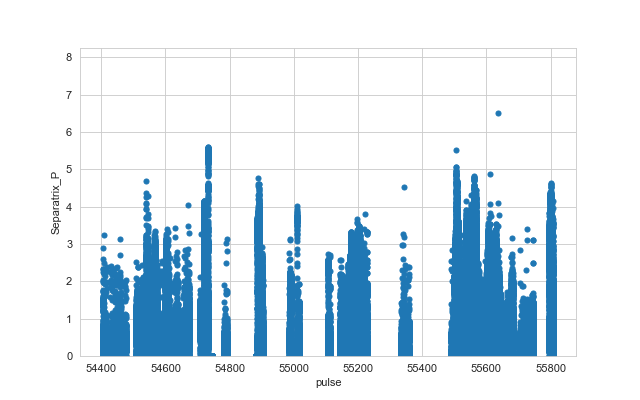

(0, 8.247197287645196)

In [31]:
fig, ax = plt.subplots()
data.plot(kind='scatter', x='pulse', y='Separatrix_P', ax=ax)
ax.set_ylim(bottom=0)

# 55226

In [32]:
_data = data.query('pulse == 55226')

<IPython.core.display.Javascript object>


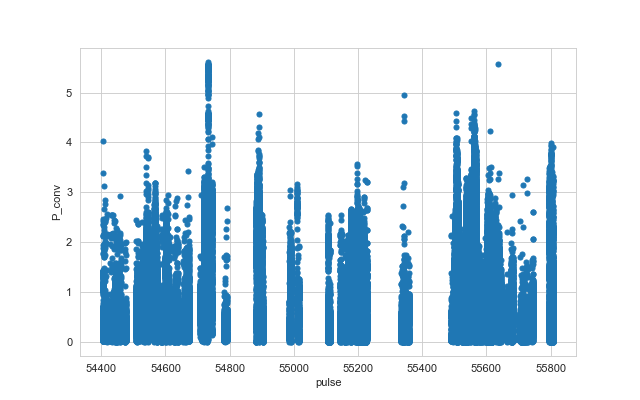

In [35]:
data.query('P_conv > 0').plot(kind='scatter', x='pulse', y='P_conv')

In [37]:
data.query('IC_P_Q2 > 200 and LH_P_tot < .1 and IC_P_Q1 < 100 and IC_P_Q4 < 100').plot(kind='scatter', 
                x='IC_delta_phi_toro_Q2_Top_LmR', y='P_conv', c='P_Ohmic', cmap='viridis')

<IPython.core.display.Javascript object>

ValueError: 'c' argument must be a mpl color, a sequence of mpl colors or a sequence of numbers, not P_Ohmic.

<IPython.core.display.Javascript object>


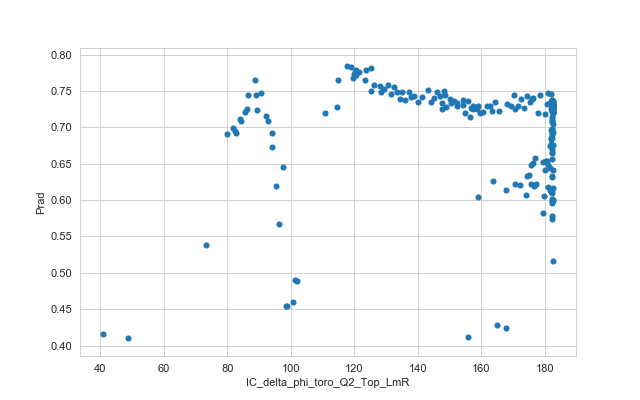

In [38]:
_data.query('IC_P_Q2 > 200').plot(kind='scatter', x='IC_delta_phi_toro_Q2_Top_LmR', y='Prad')


## 55215

In [ ]:
# keep only power larger than 200 kW
_data = data.query('pulse == 55215')
# Radiated power fraction
_data['Ptot'] = _data['LH_P_tot'] + _data['IC_P_tot']/1e3 
# increment de puissance rayonnée par rapport à la puissance rayonnée pendant la phase ohmique
_data['ratio_Pradincr'] =  np.abs(_data['Prad'] - 0.450)/_data['Ptot']*100   # 0.45 Prad during Ohmic

In [ ]:
fig, ax = plt.subplots()
_data.query('LH_P_tot > 0.2').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='LH1', s=50)
_data.query('IC_P_Q1 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q1', color='C1', s=50)
_data.query('IC_P_Q2 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q2', color='C2', s=50)
_data.query('IC_P_Q4 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q4', color='C3', s=50)
ax.legend(fontsize=14)
ax.set_ylabel('Fraction of radiated RF power [%]', fontsize=14)
ax.set_xlabel('RF power [MW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST #55215', fontsize=14)

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(_data.query('LH_P_tot > 0.2')['ratio_Pradincr'], [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(_data.query('IC_P_Q1 > 200')['ratio_Pradincr'], [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(_data.query('IC_P_Q2 > 200')['ratio_Pradincr'], [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(_data.query('IC_P_Q4 > 200')['ratio_Pradincr'], [3], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'LH1', '', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 - ', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
#ig.savefig('WEST_C4_IC_Rc_distribution_LSN_wo_LH.png', dpi=150)

# Coupling resistances

<IPython.core.display.Javascript object>


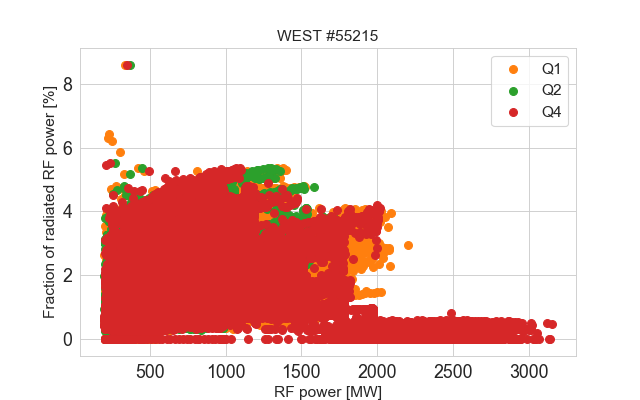

Text(0.5, 1.0, 'WEST #55215')

In [39]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 200').plot(kind='scatter', x='IC_P_Q1', y='Prad', ax=ax, label='Q1', color='C1', s=50)
data.query('IC_P_Q2 > 200').plot(kind='scatter', x='IC_P_Q2', y='Prad', ax=ax, label='Q2', color='C2', s=50)
data.query('IC_P_Q4 > 200').plot(kind='scatter', x='IC_P_Q4', y='Prad', ax=ax, label='Q4', color='C3', s=50)
ax.legend(fontsize=14)
ax.set_ylabel('Fraction of radiated RF power [%]', fontsize=14)
ax.set_xlabel('RF power [MW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST #55215', fontsize=14)

<IPython.core.display.Javascript object>


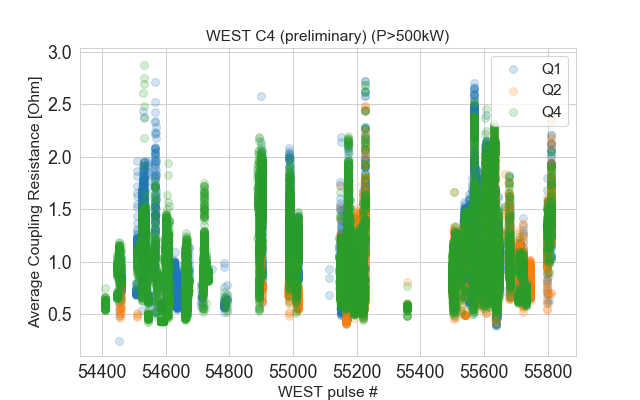

In [40]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q1_avg', ax=ax, label='Q1', color='C0', s=50, alpha=0.2)
data.query('IC_P_Q2 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q2_avg', ax=ax, label='Q2', color='C1', s=50, alpha=0.2)
data.query('IC_P_Q4 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q4_avg', ax=ax, label='Q4', color='C2', s=50, alpha=0.2)
ax.legend(fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

In [ ]:
fig.savefig('WEST_C4_IC_Rc_vs_pulse.png', dpi=150)

<IPython.core.display.Javascript object>


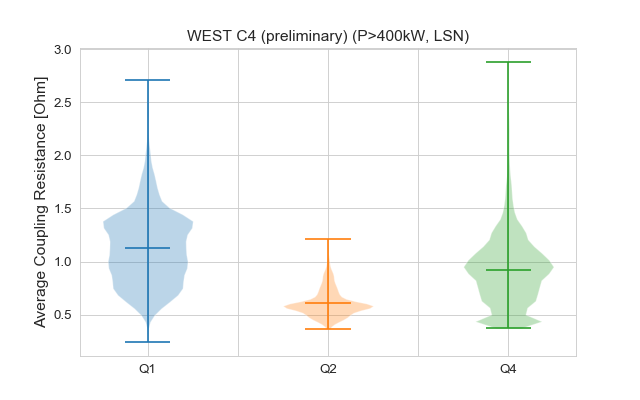

In [45]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < 55145 and Xpoint == "LSN"')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, LSN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ylim = ax.set_ylim()

In [46]:
fig.savefig('WEST_C4_IC_Rc_distribution_LSN.png', dpi=150)

<IPython.core.display.Javascript object>


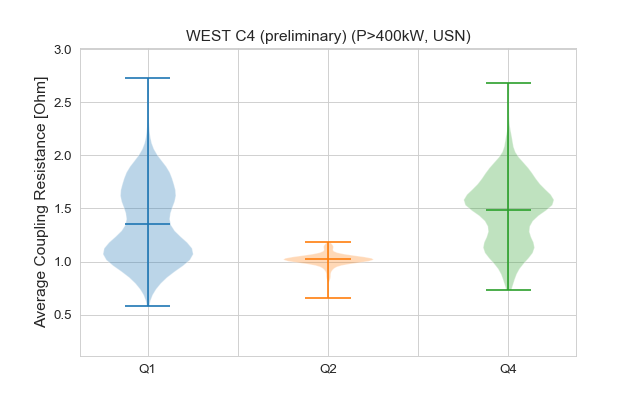

(0.11129724212844033, 3.0098581692763746)

In [42]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < 55145 and Xpoint == "USN"')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, USN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)

In [43]:
fig.savefig('WEST_C4_IC_Rc_distribution_USN.png', dpi=150)

<IPython.core.display.Javascript object>


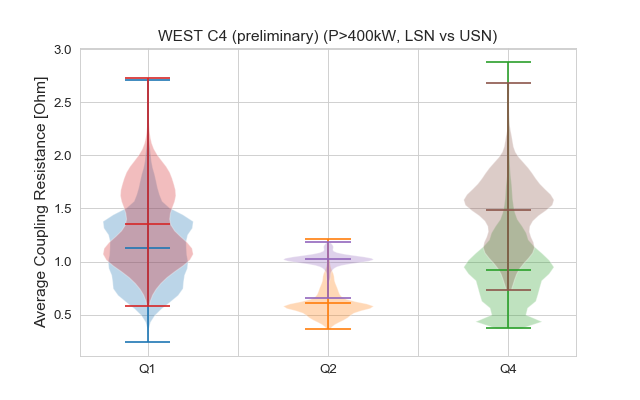

In [44]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < 55145 and Xpoint == "LSN"')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < 55145 and Xpoint == "USN"')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, LSN vs USN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ylim = ax.set_ylim()
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_vs_USN.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 500 and Xpoint == "USN"').plot(kind='scatter', y='Prad', x='IC_Rc_Q1_avg', ax=ax, label='Q1', color='C1', s=50, alpha=0.2)
data.query('IC_P_Q2 > 500 and Xpoint == "USN"').plot(kind='scatter', y='Prad', x='IC_Rc_Q2_avg', ax=ax, label='Q2', color='C2', s=50, alpha=0.2)
data.query('IC_P_Q4 > 500 and Xpoint == "USN"').plot(kind='scatter', y='Prad', x='IC_Rc_Q4_avg', ax=ax, label='Q4', color='C3', s=50, alpha=0.2)
ax.legend(fontsize=14)
#ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

In [ ]:
# Comparaison des sessions du mardi et vendredi IC only
# mardi post-boro
mardi09_03 = [54882, 54883, 54884, 54886, 54887, 54891, 54892, 54893, 54894, 54895, 54896, 54897,
              54898, 54899, 54900, 54902, 54903, 54904]             
mardi09_10 = [55014, 55015]
mardi09_17 = [55144, 55145, 55146, 55147, 55148, 55149, 55150, 55151]
# vendredi
vendredi09_13 = [55108, 55109, 55110, 55111, 55112, 55113, 55114]
vendredi09_20 = [55223, 55224, 55225, 55226, 55227]

In [ ]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_tot >= 0 and pulse in @mardi09_10').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Mardi 10/09', color='C0', s=50, alpha=0.5)
data.query('IC_P_tot >= 0 and pulse in @mardi09_17').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Mardi 17/09', color='C1', s=50, alpha=0.5)

data.query('IC_P_tot >= 0 and pulse in @vendredi09_13').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Vendredi 13/09', color='C2', s=50, marker='s', alpha=0.5)
data.query('IC_P_tot >= 0 and pulse in @vendredi09_20').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Vendredi 20/09', color='C3', s=50, marker='s', alpha=0.5)

ax.legend(fontsize=14)
#ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

In [ ]:
data['PradBulkMinusICtot'] = ( data['Prad_bulk']*1e3)/data['IC_P_tot']

fig, ax = plt.subplots()
data.query('IC_P_tot >= 400 and pulse in @mardi09_10').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Mardi 10/09', color='C0', s=50, alpha=0.5)
data.query('IC_P_tot >= 400 and pulse in @mardi09_17').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Mardi 17/09', color='C1', s=50, alpha=0.5)

data.query('IC_P_tot >= 400 and pulse in @vendredi09_13').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Vendredi 13/09', color='C2', s=50, marker='s', alpha=0.5)
data.query('IC_P_tot >= 400 and pulse in @vendredi09_20').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Vendredi 20/09', color='C3', s=50, marker='s', alpha=0.5)


ax.set_ylabel('Prad bulk/Ptot', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW, IC only shots)', fontsize=14)
ax.grid(True)

In [ ]:
fig.savefig('WEST_C4_Prad1.png', dpi=150)

In [ ]:
data['PradBulkMinusICtot'] = ( data['Prad_bulk']*1e3)/data['IC_P_tot']
data['IC_P_tot_MW'] = data['IC_P_tot']/1e3

fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_03').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 03/09', color='C0', s=50, alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_10').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 10/09', color='C1', s=50, alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_17').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 17/09', color='C2', s=50, alpha=0.5)

data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @vendredi09_13').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Vendredi 13/09', color='C3', s=50, marker='s', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @vendredi09_20').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Vendredi 20/09', color='C4', s=50, marker='s', alpha=0.5)

ax.plot([0,4], [0,0.5*4], ls='--', c='grey', alpha=0.5)
ax.plot([0,4], [0,0.6*4], ls='--', c='grey')
ax.plot([0,2.5], [0,2.5], ls='--', c='k')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_ylabel('Prad bulk [MW]', fontsize=14)
ax.set_xlabel('Total IC Power [MW] ', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>400kW, IC only shots)', fontsize=14)
ax.grid(True)
fig.savefig('WEST_C4_impact_boro.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()



data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @mardi09_03').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=True,
                                                          ax=ax, label='Mardi 03/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @mardi09_10').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=False,
                                                          ax=ax, label='Mardi 10/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @mardi09_17').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=False,
                                                          ax=ax, label='Mardi 17/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @vendredi09_13').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=False,
                                                          ax=ax, label='Vendredi 13/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @vendredi09_20').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=False,
                                                          ax=ax, label='Vendredi 20/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)



ax.set_xlim(0,400)
ax.set_ylim(bottom=0)
ax.set_ylabel('Ptot/Prad bulk [MW]', fontsize=14)
ax.set_xlabel('Toroidal Phase [deg]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>400kW, IC only shots)', fontsize=14)
ax.grid(True)

In [ ]:
fig, ax = plt.subplots()

data.plot(kind='scatter', y='IC_P_Q4', 
                                                     x='IC_Rc_Q4_avg', 
                                                     ax=ax, label='Q4', color="C2", s=50, alpha=0.5)
ax.set_xlim(0, 2.25)
ax.set_ylim(0, 3.0e3)
ax.set_xlabel('Coupling Resistance [Ohm]', fontsize=14)
ax.set_ylabel('Coupled Power [kW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
fig.savefig('WEST_C4_Q4_Rc_vs_P.png', dpi=150)

# Phasing

In [ ]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q1_Bot_LmR', 
                                 ax=ax, label='Q1', color='C0', s=50, alpha=0.2)
data.query('IC_P_Q2 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q2_Top_LmR', 
                                 ax=ax, label='Q2', color='C1', s=50, alpha=0.2)
data.query('IC_P_Q4 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q4_Top_LmR', 
                                 ax=ax, label='Q4', color='C2', s=50, alpha=0.2)
ax.legend(fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)

In [ ]:
fig.savefig('WEST_C4_IC_phase_toro.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 ')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 ')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 ')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
fig.savefig('WEST_C4_IC_Phase_toro_distribution.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
pulse_ref = 54626
ax.violinplot(data.query('IC_P_Q1 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, before phase control)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
ax.set_ylim(0,360)
fig.savefig('WEST_C4_IC_Phase_toro_distribution_before_control.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
pulse_ref = 54626
ax.violinplot(data.query('IC_P_Q1 > 400 and pulse > @pulse_ref')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > @pulse_ref')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and pulse > @pulse_ref')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, after phase control)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
ax.set_ylim(0,360)
fig.savefig('WEST_C4_IC_Phase_toro_distribution_after_control.png', dpi=150)

# LH and IC

In [ ]:
_pulses = [55215, 55216]

fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('pulse == 55214').plot(kind='scatter', x='LH_P_tot', y='IC_Rc_Q2_avg', 
                                 ax=ax, label='Q1', color='C0', s=50, alpha=0.2)
data.query('pulse == 55215').plot(kind='scatter', x='LH_P_tot', y='IC_Rc_Q2_avg', 
                                 ax=ax, label='Q1', color='C1', s=50, alpha=0.2)

ax.legend(fontsize=14)
#ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

In [ ]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.plot(kind='scatter', x='pulse', y='IC_P_tot', 
                                 ax=ax, label='P_IC', color='C0', s=50, alpha=0.2)

ax.legend(fontsize=14)
#ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)
ax.set_ylim(bottom=0)
fig.savefig('WEST_C4_P_IC_tot.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1').plot(kind='scatter', x='pulse', y='IC_Rc_Q1_avg', 
                                 ax=ax, label='Q1 w/o LH', color='C0', s=50, alpha=0.2)
data.query('LH_P_tot > 0.4').plot(kind='scatter', x='pulse', y='IC_Rc_Q1_avg', 
                                 ax=ax, label='Q1 with LH', color='C1', s=50, alpha=0.2)

In [ ]:
fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1').plot(kind='scatter', x='pulse', y='IC_Rc_Q2_avg', 
                                 ax=ax, label='Q2 w/o LH', color='C0', s=50, alpha=0.2)
data.query('LH_P_tot > 0.4').plot(kind='scatter', x='pulse', y='IC_Rc_Q2_avg', 
                                 ax=ax, label='Q2 with LH', color='C1', s=50, alpha=0.2)

In [ ]:
fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1').plot(kind='scatter', x='pulse', y='IC_Rc_Q4_avg', 
                                 ax=ax, label='Q4 w/o LH', color='C0', s=50, alpha=0.2)
data.query('LH_P_tot > 0.4').plot(kind='scatter', x='pulse', y='IC_Rc_Q4_avg', 
                                 ax=ax, label='Q4 with LH', color='C1', s=50, alpha=0.2)

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) without LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ylim = ax.set_ylim()
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_wo_LH.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w_LH.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with and w/o LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w-and-wo_LH.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse > 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse > 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with and w/o LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w-and-wo_LH.png', dpi=150)